In [9]:
import numpy as np
from scipy.optimize import minimize_scalar, minimize
import matplotlib.pyplot as plt


y_l     = 125000.0   # Initial lithospheric thickness in m          [m]
alpha_v = 3.28e-5  # volumetric coefficient of thermal expansion  [1/K]
Tm      = 1333.0     # Temperature of the mantle                    [C]
kappa   = 1e-6     # Thermal diffusivity                          [m^2/s]

# Densities of mantle, crust and water.
rhoM = 3330.0
rhoC = 2800.0
rhoW = 1030.0


#
# Initial and thermal subsidence.
#
# Assuming instantaneous rifting.
#

def syn_rift_subsidence(beta, tc):
    # Assuming subsidence filled with water (no sediment).
    return (y_l * (1 - 1 / beta) *
            ((rhoM - rhoC) * (tc / y_l) * (1 - alpha_v * Tm * tc / y_l) - alpha_v * Tm * rhoM / 2.0) /
            (rhoM * (1 - alpha_v * Tm) - rhoW))

def post_rift_subsidence(beta, time_my):
    time_s  = time_my*365*24*3600*1e6;        # Time in seconds
    E0 = 4 * y_l * rhoM * alpha_v * Tm / ((np.pi ** 2) * (rhoM - rhoW))
    tau = (y_l ** 2) / ((np.pi ** 2) * kappa)
    # Thermal Subsidence as a function of time
    return E0 * (beta / np.pi) * np.sin(np.pi / beta) * (1 - np.exp(-time_s / tau))

def total_subsidence(beta, tc_stretched, rift_end):
    # Initial crustal thickness is beta times stretched/final crustal thickness.
    tc_initial = beta * tc_stretched
    return syn_rift_subsidence(beta, tc_initial) + post_rift_subsidence(beta, rift_end)


#
# Calculate stretching factor (beta) by minimizing difference between actual subsidence and
# subsidence calculated from beta (using above functions).
#

def calc_beta(
        tc_stretched,
        rift_end,
        actual_subsidence,
        use_minimize_scalar = True):

    min_beta = 1.0
    # Initial crustal thickness cannot exceed initial lithospheric thickness...
    max_beta = y_l / tc_stretched

    # Run scipt optimisation.
    if use_minimize_scalar:
        def obj_f(beta):
            return np.abs(actual_subsidence - total_subsidence(beta, tc_stretched, rift_end))

        res = minimize_scalar(
                obj_f,
                bounds=(min_beta, max_beta),
                method='bounded',
                options={'maxiter' : 100})
    else:
        def obj_f(beta):
            # Need to restrict beta manually since COBYLA does not support bounds.
            beta = np.where(beta < min_beta, min_beta, beta)
            beta = np.where(beta > max_beta, max_beta, beta)
            #beta = max(beta, min_beta)
            #beta = min(beta, max_beta)
            return np.abs(actual_subsidence - total_subsidence(beta, tc_stretched, rift_end))

        # Initial guess for beta is 1.0.
        res = minimize(
                obj_f,
                1.0,
                method='COBYLA',
                #bounds=(min_beta, max_beta),
                #constraints = {'type': 'ineq', 'fun': lambda x:  x - 1},
                options={'maxiter' : 100})

    return res['x'], res['fun']

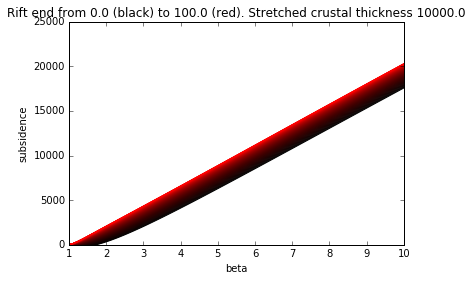

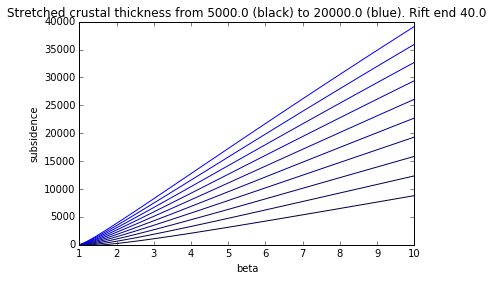

In [10]:
#
# First some simple plots of subsidence vs beta.
#

tc_stretched = 10000.0
tc_stretched_array = np.linspace(5000.0, 20000.0, 10)
beta_array = np.linspace(1.0, 10.0, 80)
rift_end = 40.0
rift_end_array = np.linspace(0.0, 100.0, 80)

fig, axes = plt.subplots()
for rift_end_sample in rift_end_array:
    axes.plot(
        beta_array,
        total_subsidence(beta_array, tc_stretched, rift_end_sample),
        color=(rift_end_sample / rift_end_array[-1], 0.0, 0.0),
        label='rift_end={0}'.format(rift_end_sample))
plt.xlabel('beta')
plt.ylabel('subsidence')
plt.title('Rift end from {0} (black) to {1} (red). Stretched crustal thickness {2}'.format(
        rift_end_array[0], rift_end_array[-1], tc_stretched))
axes.set_xlim(left=1.0)
axes.set_ylim(bottom=0.0)
plt.show()

fig, axes = plt.subplots()
for tc_stretched_sample in tc_stretched_array:
    axes.plot(
        beta_array,
        total_subsidence(beta_array, tc_stretched_sample, rift_end),
        color=(0.0, 0.0, tc_stretched_sample / tc_stretched_array[-1]),
        label='tc_stretched={0}'.format(tc_stretched_sample))
plt.xlabel('beta')
plt.ylabel('subsidence')
plt.title('Stretched crustal thickness from {0} (black) to {1} (blue). Rift end {2}'.format(
        tc_stretched_array[0], tc_stretched_array[-1], rift_end))
axes.set_xlim(left=1.0)
axes.set_ylim(bottom=0.0)
plt.show()

#rift_end = np.linspace(0.0, 100.0, 80)
#beta = np.empty(rift_end.size)
#beta.fill(2.0)
#plt.plot(rift_end, total_subsidence(beta, tc_stretched, rift_end))
#plt.xlabel('rift_end')
#plt.ylabel('subsidence')
#plt.show()

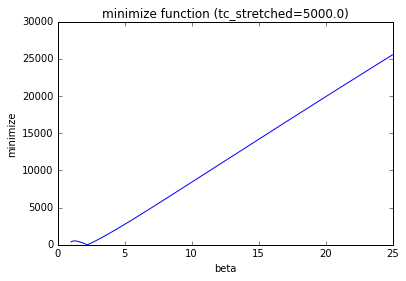

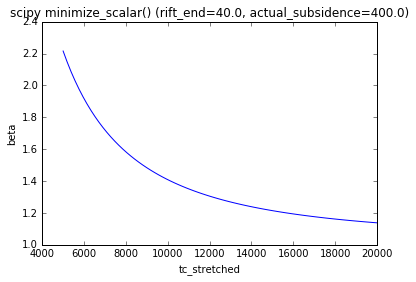

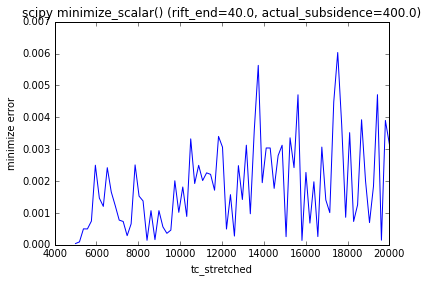

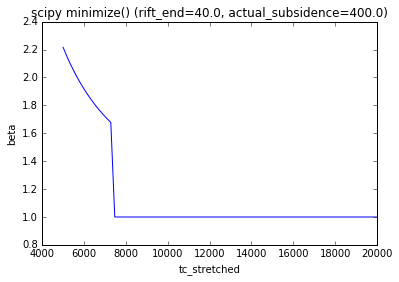

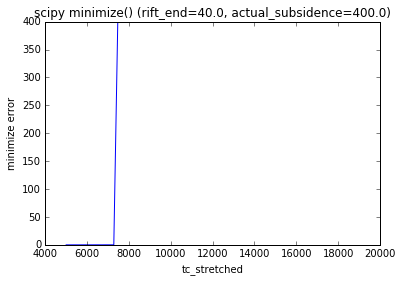

In [13]:
#
# Now some plots of minmized beta vs stretched crustal thickness.
#

tc_stretched = 5000.0
rift_end = 40.0
actual_subsidence = 400.0
min_beta = 1.0
# Initial crustal thickness cannot exceed initial lithospheric thickness...
max_beta = y_l / tc_stretched


beta_array = np.linspace(min_beta, max_beta, 200)
plt.plot(beta_array, np.abs(actual_subsidence - total_subsidence(beta_array, tc_stretched, rift_end)))
plt.xlabel('beta')
plt.ylabel('minimize')
plt.title('minimize function (tc_stretched={0})'.format(tc_stretched))
plt.show()

tc_stretched_array = np.linspace(5000.0, 20000.0, 80)

#
# Scipy 'minimize_scalar()' works fine.
#

plt.plot(
        tc_stretched_array,
        [calc_beta(tc_stretched_sample, rift_end, actual_subsidence)[0]
            for tc_stretched_sample in tc_stretched_array])
plt.xlabel('tc_stretched')
plt.ylabel('beta')
plt.title('scipy minimize_scalar() (rift_end={0}, actual_subsidence={1})'.format(rift_end, actual_subsidence))
plt.show()

plt.plot(
        tc_stretched_array,
        [calc_beta(tc_stretched_sample, rift_end, actual_subsidence)[1]
            for tc_stretched_sample in tc_stretched_array])
plt.xlabel('tc_stretched')
plt.ylabel('minimize error')
plt.title('scipy minimize_scalar() (rift_end={0}, actual_subsidence={1})'.format(rift_end, actual_subsidence))
plt.show()


#
# But Scipy 'minimize()' does not always work (as shown below).
#

plt.plot(
        tc_stretched_array,
        [calc_beta(tc_stretched_sample, rift_end, actual_subsidence, False)[0]
            for tc_stretched_sample in tc_stretched_array])
plt.xlabel('tc_stretched')
plt.ylabel('beta')
plt.title('scipy minimize() (rift_end={0}, actual_subsidence={1})'.format(rift_end, actual_subsidence))
plt.show()

plt.plot(
        tc_stretched_array,
        [calc_beta(tc_stretched_sample, rift_end, actual_subsidence, False)[1]
            for tc_stretched_sample in tc_stretched_array])
plt.xlabel('tc_stretched')
plt.ylabel('minimize error')
plt.title('scipy minimize() (rift_end={0}, actual_subsidence={1})'.format(rift_end, actual_subsidence))
plt.show()